In [ ]:
!pip3 install pickle5

     |████████████████████████████████| 256 kB 7.7 MB/s 


Define Model and split/scale the dataset

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import seed

import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import pickle5 as pickle
from sklearn.preprocessing import StandardScaler

# taken from https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model


import matplotlib.pyplot as plt

if __name__ == "__main__":
  path = "/content/"
  tc_set_name = "mean"
  file_name = 'feature_'+tc_set_name+'_tc_'
  tc1_features = []
  tc2_features = []
  tc3_features = []
  tc4_features = []
  for i in range(5):
      with open(path + file_name +"0_f_" + str(i) + ".pkl", "rb") as fh:
          tc1 = pickle.load(fh)
      tc1_features.append(tc1)
      with open(path + file_name +"1_f_"+ str(i) + ".pkl", "rb") as fh:
          tc2 = pickle.load(fh)
      tc2_features.append(tc2)
      with open(path + file_name +"2_f_" + str(i) + ".pkl", "rb") as fh:
          tc3 = pickle.load(fh)
      tc3_features.append(tc3)
      with open(path + file_name +"3_f_" + str(i) + ".pkl", "rb") as fh:
          tc4 = pickle.load(fh)
      tc4_features.append(tc4)

  #drop welch_density and last_location of minimum because they are not needed
  if True:
      [df.drop('spkt_welch_density_mean', axis=1, inplace=True) for df in tc1_features]
      [df.drop('spkt_welch_density_mean', axis=1, inplace=True) for df in tc2_features]
      [df.drop('spkt_welch_density_mean', axis=1, inplace=True) for df in tc3_features]
      [df.drop('spkt_welch_density_mean', axis=1, inplace=True) for df in tc4_features]
      [df.drop('value__last_location_of_minimum', axis=1, inplace=True) for df in tc1_features]
      [df.drop('value__last_location_of_minimum', axis=1, inplace=True) for df in tc2_features]
      [df.drop('value__last_location_of_minimum', axis=1, inplace=True) for df in tc3_features]
      [df.drop('value__last_location_of_minimum', axis=1, inplace=True) for df in tc4_features]

  scaler = StandardScaler()

  data_tc1 = np.hstack(tc1_features)
  data_tc2 =  np.hstack(tc2_features)
  data_tc3 =  np.hstack(tc3_features)
  data_tc4 =  np.hstack(tc4_features)

  X_train_raw = np.vstack([data_tc1, data_tc4])
  X_train_raw = scaler.fit_transform(X_train_raw)
  X_train = X_train_raw.reshape(X_train_raw.shape[0], 1, X_train_raw.shape[1])

  # create test set
  X_test_tc2 = scaler.transform(data_tc2).reshape(data_tc2.shape[0], 1, data_tc2.shape[1])
  X_test_tc3 = scaler.transform(data_tc3).reshape(data_tc3.shape[0], 1, data_tc3.shape[1])
 

1.543779129214068e-05
7.134628076365776e-05
(222, 185)
Trainset shape:
(674, 1, 185)
52247769.021294594
327.8553192444035
236.71310795424188
Testset shape:
(222, 1, 185)
(368, 1, 185)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 185)]          0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             12928     
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

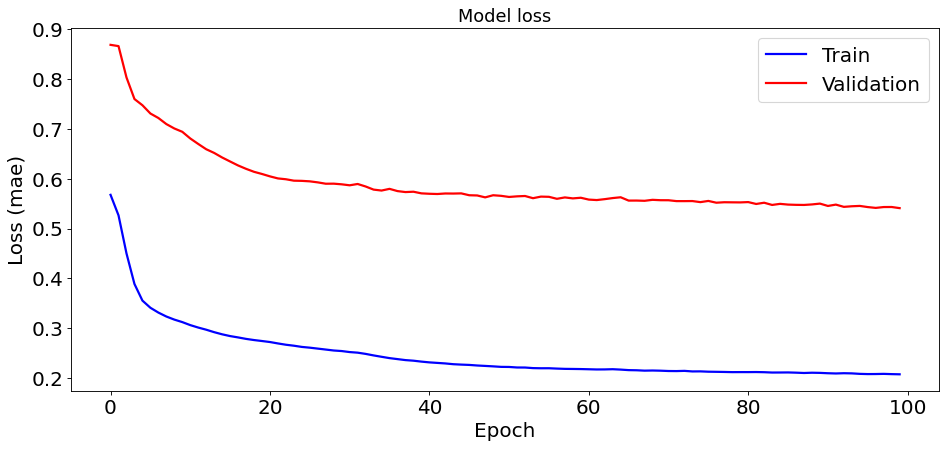

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                validation_split=0.1, callbacks=[callback]).history

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:

#for tc 2 
X_pred2 = model.predict(X_test_tc2)
X_pred2 = X_pred2.reshape(X_pred2.shape[0], X_pred2.shape[2])
scored_mean_tc2 = pd.DataFrame()
X_test3 = X_test_tc2.reshape(X_test_tc2.shape[0], X_test_tc2.shape[2])
scored_mean_tc2['Loss_mae'] = np.mean(np.abs(X_pred2.squeeze()-X_test_tc2.squeeze()), axis = 1)

#for tc 3 
X_pred3 = model.predict(X_test_tc3)
X_pred3 = X_pred3.reshape(X_pred3.shape[0], X_pred3.shape[2])
scored_mean_tc3 = pd.DataFrame()
X_test3 = X_test_tc3.reshape(X_test_tc3.shape[0], X_test_tc3.shape[2])
scored_mean_tc3['Loss_mae'] = np.mean(np.abs(X_pred3.squeeze()-X_test_tc3.squeeze()), axis = 1)



In [ ]:
  # save reconstruction loss
  scored_mean_tc2.to_pickle("/content/tc2_reconstruction_loss.pkl")
  scored_mean_tc3.to_pickle("/content/tc3_reconstruction_loss.pkl")

222


In [ ]:
number_of_res = 8
sorted_score_tc2 = scored_mean_tc2.sort_values('Loss_mae', ascending=False)[:number_of_res]
sorted_score_tc3 = scored_mean_tc3.sort_values('Loss_mae', ascending=False)[:number_of_res]

#p_lst2 = list(zip(sorted_score_tc2.index, [x for [x] in sorted_score_tc2.values]))
#p_lst3 = list(zip(sorted_score_tc3.index, [x for [x] in sorted_score_tc3.values]))

print("Anomaly tc2")
print(sorted_score_tc2)
#print(p_lst2)
print("Anomaly tc3")
print(sorted_score_tc3)
#print(p_lst3)

tc2_anomaly_ids = sorted_score_tc2[:number_of_res].index
tc3_anomaly_ids = sorted_score_tc3[:number_of_res].index

Int64Index([127, 59, 156, 61, 170, 11, 221, 155], dtype='int64')
Int64Index([42, 72, 26, 1, 217, 59, 261, 24], dtype='int64')
Anomaly tc2
     Loss_mae
127  3.962435
59   3.728642
156  3.463081
61   3.306298
170  2.671768
11   2.618767
221  2.571205
155  2.533536
[(127, 3.962435414249235), (59, 3.7286423124947454), (156, 3.4630809764652697), (61, 3.3062975815379154), (170, 2.67176765994998), (11, 2.618767350023085), (221, 2.5712046069181658), (155, 2.533535564488259)]
Anomaly tc3
     Loss_mae
42   4.842931
72   4.402918
26   3.438631
1    3.423804
217  3.334009
59   3.130203
261  3.038441
24   2.945305
[(42, 4.842930565831453), (72, 4.402917625910828), (26, 3.4386305053307065), (1, 3.4238035155610236), (217, 3.334008890758435), (59, 3.1302026153901847), (261, 3.0384409819654223), (24, 2.9453053766028754)]


In [ ]:
number_of_res = 8
sorted_score_tc2 = scored_mean_tc2.sort_values('Loss_mae')[:number_of_res]
sorted_score_tc3 = scored_mean_tc3.sort_values('Loss_mae')[:number_of_res]
#p_lst2 = list(zip(sorted_score_tc2.index, [x for [x] in sorted_score_tc2.values]))
#p_lst3 = list(zip(sorted_score_tc3.index, [x for [x] in sorted_score_tc3.values]))
print("Normal tc2")
print(sorted_score_tc2)
#print(p_lst2)
print("Normal tc3")
print(sorted_score_tc3)
#print(p_lst3)

tc2_normal_ids = sorted_score_tc2[:number_of_res].index
tc3_normal_ids = sorted_score_tc3[:number_of_res].index

Normal tc2
     Loss_mae
72   0.328777
39   0.379707
37   0.387146
17   0.402423
208  0.425562
77   0.427744
90   0.436182
204  0.460521
[(72, 0.32877720376945074), (39, 0.37970714521931304), (37, 0.3871461884280222), (17, 0.4024229652372485), (208, 0.4255621648371539), (77, 0.4277443534434529), (90, 0.43618200282204267), (204, 0.46052126575069563)]
Normal tc3
    Loss_mae
40  0.281645
75  0.293495
41  0.300744
39  0.304901
19  0.345517
38  0.355724
7   0.370031
28  0.390127
[(40, 0.2816454931056612), (75, 0.2934947665428949), (41, 0.3007442000341538), (39, 0.30490140866805965), (19, 0.34551665058595576), (38, 0.35572390532521253), (7, 0.3700313710363196), (28, 0.3901270326907771)]


In [ ]:
input_channel  = ['ANALOG_IN', 'IM_MIS', 'IP_MIS', 'ITR_MIS', 'SCINT_MIS']
feature_names = []
for c in input_channel:
  for f in tc2_features[0].columns:
      feature_names.append(c + "_" + f)
loss2 = np.abs(X_pred2.squeeze()-X_test_tc2.squeeze())
loss_df2 = pd.DataFrame(loss2, columns=feature_names)

loss3 = np.abs(X_pred3.squeeze()-X_test_tc3.squeeze())
loss_df3 = pd.DataFrame(loss3, columns=feature_names)
#print(np.abs(X_pred.squeeze()-X_test.squeeze()))

In [ ]:
print("testcase 2")
for a in tc2_anomaly_ids:
  print(a)
  r = loss_df2.loc[a].sort_values(ascending=False)
  print(r[:10])

print("\ntestcase 3")
for a in tc3_anomaly_ids:
  print(a)
  r = loss_df3.loc[a].sort_values(ascending=False)
  print(r[:15])

testcase 2
59
IP_MIS_c3_lag_mean                      327.937933
IP_MIS_value__variance                   41.398175
IP_MIS_fft_coeff_imag_mean               39.957126
IP_MIS_fft_coeff_abs_mean                34.922796
IP_MIS_fft_coeff_intercept_min_mean      24.894042
IP_MIS_fft_coeff_real_mean               23.904192
IP_MIS_fft_coeff_slope_min_mean          22.300833
IP_MIS_fft_coeff_intercept_mean_mean     11.641966
IP_MIS_fft_coeff_slope_mean_mean         11.561535
IP_MIS_value__standard_deviation         11.152557
Name: 59, dtype: float64
127
IM_MIS_fft_coeff_imag_mean             31.964994
ANALOG_IN_value__count_below_mean      30.255736
IM_MIS_fft_coeff_abs_mean              26.971708
IM_MIS_fft_coeff_real_mean             25.309944
ANALOG_IN_ratio_beyond_r_sigma_mean    17.059892
IP_MIS_fft_coeff_imag_mean             15.773136
ANALOG_IN_fft_coeff_rval_min_mean      14.592342
ANALOG_IN_fft_coeff_rval_max_mean      14.583188
ANALOG_IN_fft_coeff_rval_mean_mean     14.453794
ANALOG

In [ ]:
print("testcase 2 normal")
for a in tc2_normal_ids:
  print(a)
  r = loss_df2.loc[a].sort_values(ascending=False)
  print(r[:10])

print("\ntestcase 3 normal")
for a in tc3_normal_ids:
  print(a)
  r = loss_df3.loc[a].sort_values(ascending=False)
  print(r[:10])

print("#####")
print(loss_df2.loc[21]['IP_MIS_value__variance'])

testcase 2 normal
72
ANALOG_IN_ar_coefficient_mean               2.629036
ANALOG_IN_value__maximum                    2.439211
SCINT_MIS_fft_coeff_rval_max_mean           2.053544
IM_MIS_value__kurtosis                      2.049041
IM_MIS_value__skewness                      1.777751
IP_MIS_value__first_location_of_minimum     1.724223
SCINT_MIS_ar_coefficient_mean               1.596832
ANALOG_IN_value__variance                   1.584084
IP_MIS_ar_coefficient_mean                  1.458977
ITR_MIS_value__first_location_of_minimum    1.432282
Name: 72, dtype: float64
37
IM_MIS_value__kurtosis                      3.618817
ITR_MIS_value__last_location_of_maximum     2.885794
ITR_MIS_value__first_location_of_maximum    2.841434
IM_MIS_value__skewness                      2.137405
ANALOG_IN_fft_coeff_stderr_min_mean         2.028877
SCINT_MIS_fft_coeff_rval_max_mean           1.954511
ITR_MIS_fft_coeff_rval_var_mean             1.951020
ITR_MIS_fft_coeff_rval_max_mean             1.8155

In [ ]:
res =tc2_features[2].loc[61]
re2 = tc2_features[2].loc[37]
#for c, val in enumerate(res):
#  print("a: " + str(val) + " no: " + str(re2[c]))
print(res)
print(re2)

value__standard_deviation               0.155057
value__variance                         0.024043
value__skewness                         0.306580
value__kurtosis                        -1.886772
value__count_above_mean             44631.000000
value__count_below_mean             60032.000000
value__last_location_of_maximum         0.996111
value__first_location_of_maximum        0.996102
value__first_location_of_minimum        0.318279
value__maximum                          0.343314
value__minimum                          0.004885
c3_lag_mean                             0.013089
number_peaks_mean                   11211.200000
fft_coeff_real_mean                  3168.600335
fft_coeff_imag_mean                  2537.642713
fft_coeff_abs_mean                   5543.941797
fft_coeff_angle_mean                   72.052515
fft_coeff_rval_max_mean                 0.836761
fft_coeff_rval_min_mean                 0.860577
fft_coeff_rval_mean_mean                0.869509
fft_coeff_rval_var_m

In [ ]:
print("testcase 2")
for a in tc2_anomaly_ids:
  print(a)
  r = abs(loss_df2.loc[a]-loss_df2.mean()).sort_values(ascending=False)
  print(r[:5])

print("testcase 3")
print(loss_df3.mean())
for a in tc3_anomaly_ids:
  print(a)
  r = abs(loss_df3.loc[a]-loss_df3.mean()).sort_values(ascending=False)
  print(r[:5])

testcase 2
59
IP_MIS_c3_lag_mean            318.310249
IP_MIS_value__variance         38.184191
IP_MIS_fft_coeff_imag_mean     34.581617
IP_MIS_fft_coeff_abs_mean      30.515700
IP_MIS_fft_coeff_real_mean     20.277508
dtype: float64
127
ANALOG_IN_value__count_below_mean      29.125608
IM_MIS_fft_coeff_imag_mean             28.699496
IM_MIS_fft_coeff_abs_mean              23.779079
IM_MIS_fft_coeff_real_mean             22.018067
ANALOG_IN_ratio_beyond_r_sigma_mean    16.225924
dtype: float64
156
IP_MIS_c3_lag_mean                     268.566021
IP_MIS_value__variance                  37.894453
IP_MIS_fft_coeff_intercept_min_mean     32.280870
IP_MIS_fft_coeff_imag_mean              30.959799
IP_MIS_fft_coeff_abs_mean               24.030479
dtype: float64
61
IP_MIS_c3_lag_mean                     230.811410
IP_MIS_fft_coeff_intercept_min_mean     37.399011
IP_MIS_value__variance                  37.123643
IP_MIS_fft_coeff_imag_mean              26.194102
IP_MIS_fft_coeff_slope_min_mea

**Plots of Latentspace**

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
encoder = Model(inputs=model.input, outputs=model.layers[2].output)
#encoder.summary()

latent_space_tc2 = encoder.predict(X_test_tc2)
latent_space_tc3 = encoder.predict(X_test_tc3)

tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
#tsne = TSNE(n_components=2, random_state=0)
pca = PCA(n_components=2)

tc2_input_features_2d = tsne.fit_transform(X_test_tc2.squeeze())
tc3_input_features_2d = tsne.fit_transform(X_test_tc3.squeeze())

X_2d_tc2 = tsne.fit_transform(latent_space_tc2)
X_2d_tc3 = tsne.fit_transform(latent_space_tc3)

tc2_input_features_2d_pca =  pca.fit_transform(X_test_tc2.squeeze())
tc3_input_features_2d_pca =  pca.fit_transform(X_test_tc3.squeeze())

X_2d_tc2_pca =  pca.fit_transform(latent_space_tc2)
X_2d_tc3_pca =  pca.fit_transform(latent_space_tc3)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


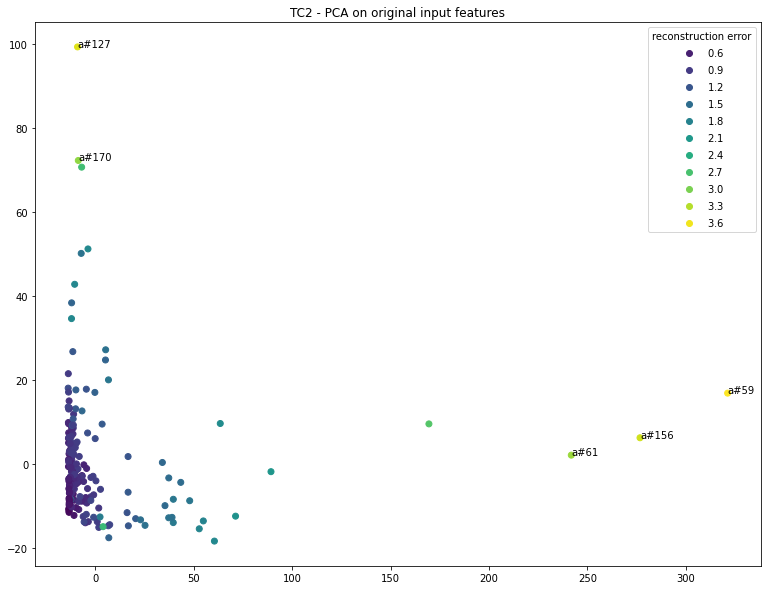

In [ ]:
plt.figure(figsize=(13, 10))
scatter = plt.scatter(tc2_input_features_2d_pca[:,0], tc2_input_features_2d_pca[:,1], c=scored_mean_tc2.values)
plt.title("TC2 - PCA on original input features")
for ano in tc2_anomaly_ids:
  plt.annotate("a#{id}".format(id=ano), (tc2_input_features_2d_pca[ano,0], tc2_input_features_2d_pca[ano,1]))

plt.legend(*scatter.legend_elements(), title="reconstruction error")

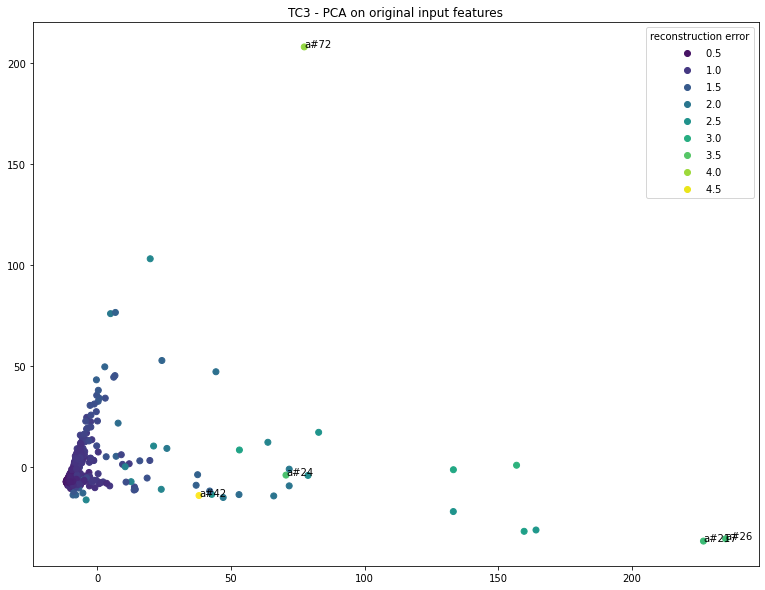

In [ ]:
plt.figure(figsize=(13, 10))
scatter = plt.scatter(tc3_input_features_2d_pca[:,0], tc3_input_features_2d_pca[:,1], c=scored_mean_tc3.values)
plt.title("TC3 - PCA on original input features")
for ano in tc3_anomaly_ids:
  plt.annotate("a#{id}".format(id=ano), (tc3_input_features_2d_pca[ano,0], tc3_input_features_2d_pca[ano,1]))

plt.legend(*scatter.legend_elements(), title="reconstruction error")

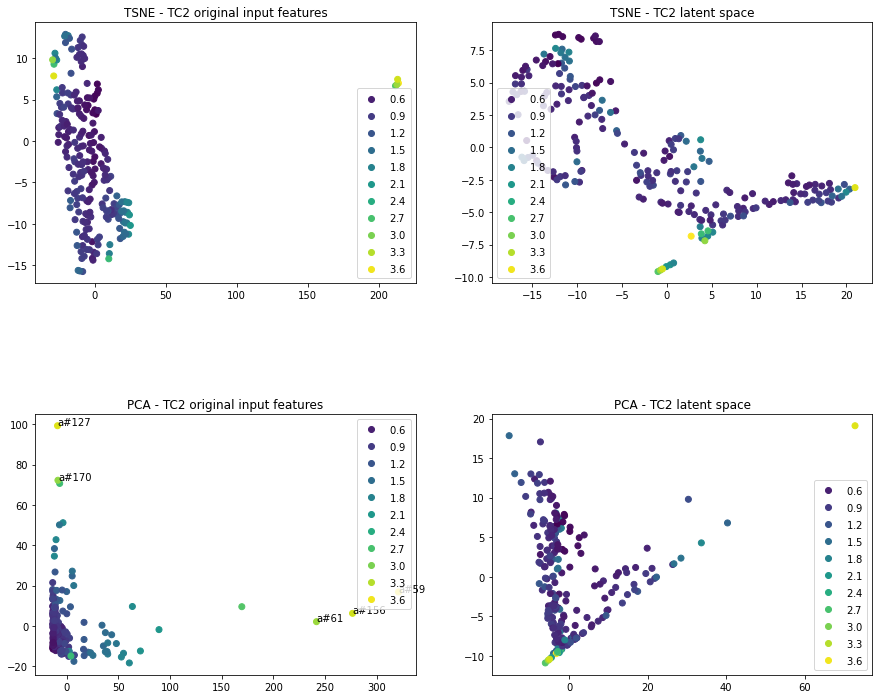

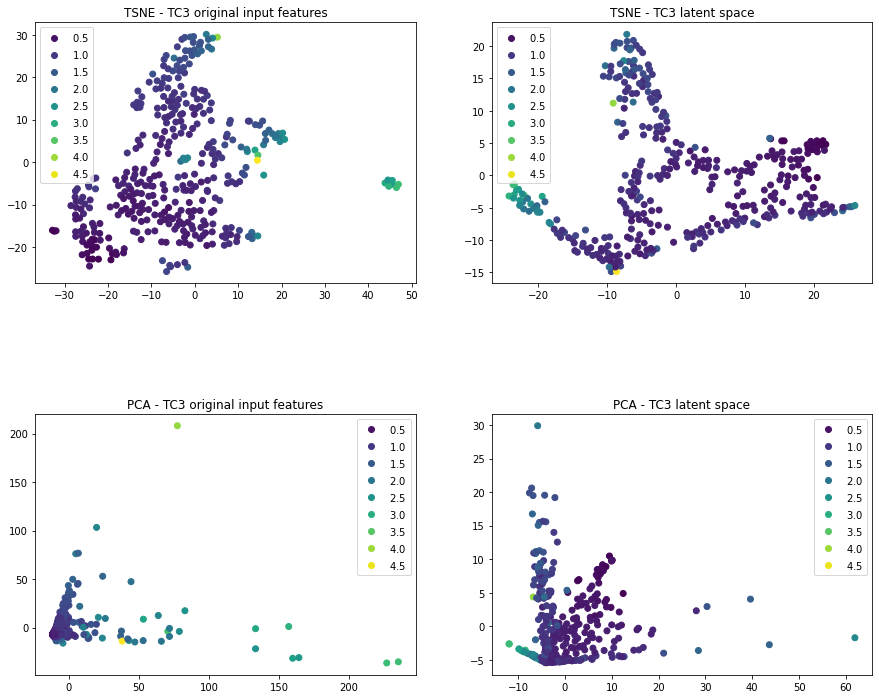

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
ax = plt.subplot(2, 2, 1)
scatter = plt.scatter(tc2_input_features_2d[:,0], tc2_input_features_2d[:,1], c=scored_mean_tc2.values)
ax.set_title("TSNE - TC2 original input features")
plt.legend(*scatter.legend_elements())

ax = plt.subplot(2, 2, 2)
scatter = plt.scatter(X_2d_tc2[:,0], X_2d_tc2[:,1], c=scored_mean_tc2.values)
ax.set_title("TSNE - TC2 latent space")
plt.legend(*scatter.legend_elements())


ax = plt.subplot(2, 2, 3)
scatter = plt.scatter(tc2_input_features_2d_pca[:,0], tc2_input_features_2d_pca[:,1], c=scored_mean_tc2.values)
ax.set_title("PCA - TC2 original input features")
for ano in tc2_anomaly_ids:
  plt.annotate("a#{id}".format(id=ano), (tc2_input_features_2d_pca[ano,0], tc2_input_features_2d_pca[ano,1]))

plt.legend(*scatter.legend_elements())


ax = plt.subplot(2, 2, 4)
scatter = plt.scatter(X_2d_tc2_pca[:,0], X_2d_tc2_pca[:,1], c=scored_mean_tc2.values)
ax.set_title("PCA - TC2 latent space")
plt.legend(*scatter.legend_elements())
plt.show()


######################## TC3 ###############################


plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
ax = plt.subplot(2, 2, 1)
scatter = plt.scatter(tc3_input_features_2d[:,0], tc3_input_features_2d[:,1], c=scored_mean_tc3.values)
ax.set_title("TSNE - TC3 original input features")
plt.legend(*scatter.legend_elements())

ax = plt.subplot(2, 2, 2)
scatter = plt.scatter(X_2d_tc3[:,0], X_2d_tc3[:,1], c=scored_mean_tc3.values)
ax.set_title("TSNE - TC3 latent space")
plt.legend(*scatter.legend_elements())


ax = plt.subplot(2, 2, 3)
scatter = plt.scatter(tc3_input_features_2d_pca[:,0], tc3_input_features_2d_pca[:,1], c=scored_mean_tc3.values)
ax.set_title("PCA - TC3 original input features")

plt.legend(*scatter.legend_elements())


ax = plt.subplot(2, 2, 4)
scatter = plt.scatter(X_2d_tc3_pca[:,0], X_2d_tc3_pca[:,1], c=scored_mean_tc3.values)
ax.set_title("PCA - TC3 latent space")
plt.legend(*scatter.legend_elements())
plt.show()


In [ ]:
tsne = TSNE(n_components=3, learning_rate='auto', init='pca')
pca = PCA(n_components=3)

tc2_input_features_3d = tsne.fit_transform(X_test_tc2.squeeze())
tc3_input_features_3d = tsne.fit_transform(X_test_tc3.squeeze())

X_3d_tc2 = tsne.fit_transform(latent_space_tc2)
X_3d_tc3 = tsne.fit_transform(latent_space_tc3)

tc2_input_features_3d_pca =  pca.fit_transform(X_test_tc2.squeeze())
tc3_input_features_3d_pca =  pca.fit_transform(X_test_tc3.squeeze())

X_3d_tc2_pca =  pca.fit_transform(latent_space_tc2)
X_3d_tc3_pca =  pca.fit_transform(latent_space_tc3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


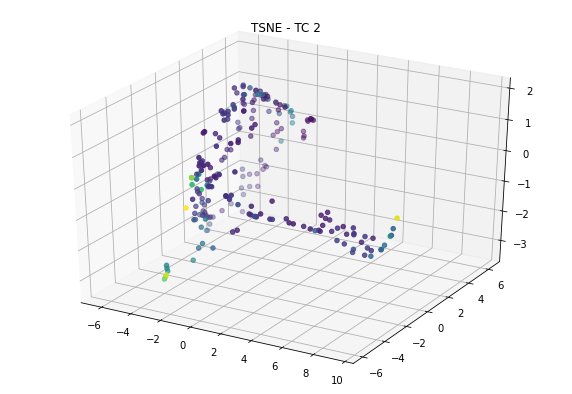

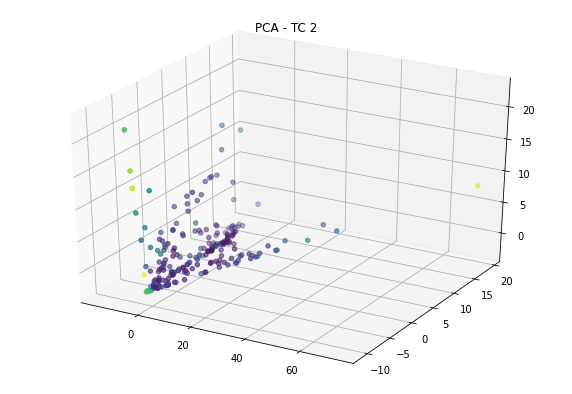

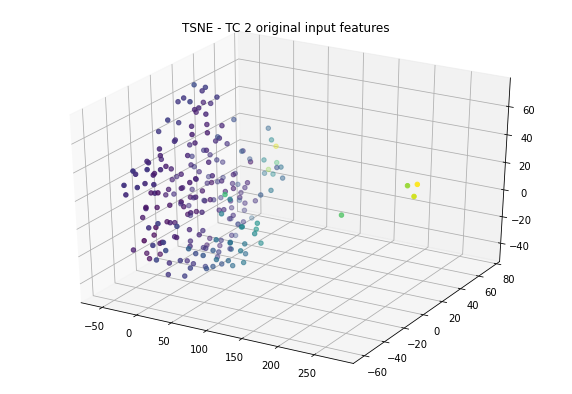

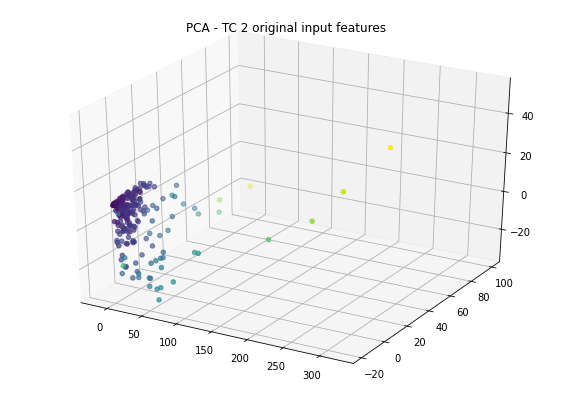

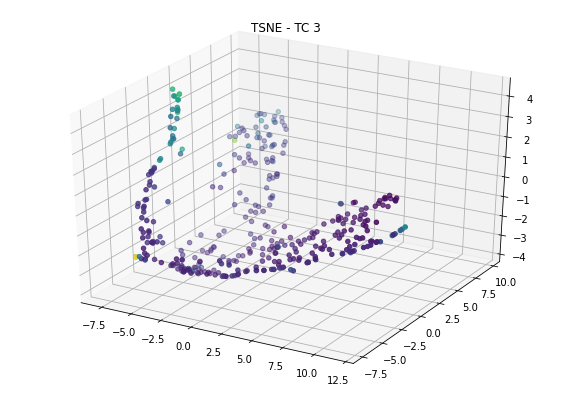

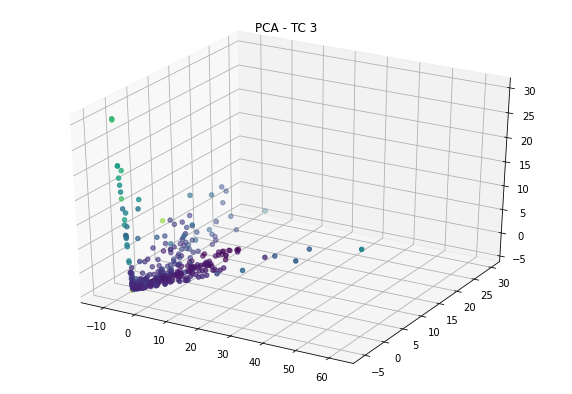

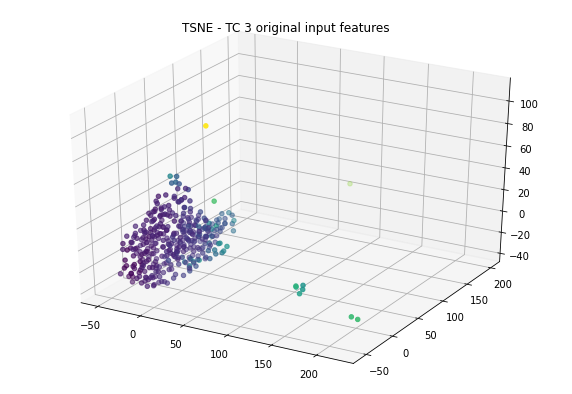

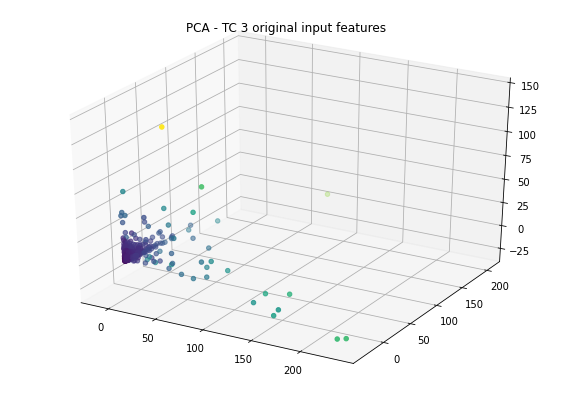

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_3d_tc2[:,0], X_3d_tc2[:,1], X_3d_tc2[:,2], c =scored_mean_tc2.values)
plt.title("TSNE - TC 2")
plt.show()
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_3d_tc2_pca[:,0], X_3d_tc2_pca[:,1], X_3d_tc2_pca[:,2], c =scored_mean_tc2.values)
plt.title("PCA - TC 2")
plt.show()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(tc2_input_features_3d[:,0], tc2_input_features_3d[:,1], tc2_input_features_3d[:,2], c =scored_mean_tc2.values)
plt.title("TSNE - TC 2 original input features")
plt.show()
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(tc2_input_features_3d_pca[:,0], tc2_input_features_3d_pca[:,1], tc2_input_features_3d_pca[:,2], c =scored_mean_tc2.values)
plt.title("PCA - TC 2 original input features")
plt.show()

########################## TC 3 #################################

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_3d_tc3[:,0], X_3d_tc3[:,1], X_3d_tc3[:,2], c =scored_mean_tc3.values)
plt.title("TSNE - TC 3")
plt.show()
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_3d_tc3_pca[:,0], X_3d_tc3_pca[:,1], X_3d_tc3_pca[:,2], c =scored_mean_tc3.values)
plt.title("PCA - TC 3")
plt.show()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(tc3_input_features_3d[:,0], tc3_input_features_3d[:,1], tc3_input_features_3d[:,2], c =scored_mean_tc3.values)
plt.title("TSNE - TC 3 original input features")
plt.show()
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(tc3_input_features_3d_pca[:,0], tc3_input_features_3d_pca[:,1], tc3_input_features_3d_pca[:,2], c =scored_mean_tc3.values)
plt.title("PCA - TC 3 original input features")
plt.show()

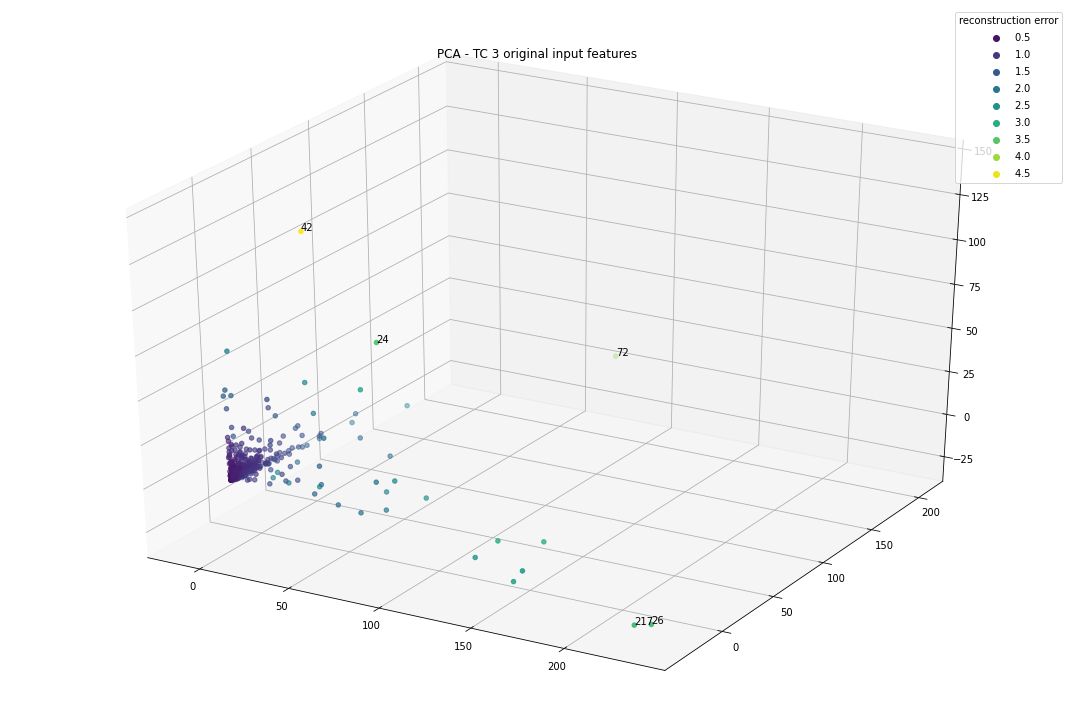

In [ ]:
fig = plt.figure(figsize = (19, 13))
ax = plt.axes(projection ="3d")
ax.scatter3D(tc3_input_features_3d_pca[:,0], tc3_input_features_3d_pca[:,1], tc3_input_features_3d_pca[:,2], c =scored_mean_tc3.values)
plt.title("PCA - TC 3 original input features")
for ano in tc3_anomaly_ids:
    ax.text(tc3_input_features_3d_pca[ano,0],tc3_input_features_3d_pca[ano,1],tc3_input_features_3d_pca[ano,2],ano)
plt.legend(*scatter.legend_elements(), title="reconstruction error")
plt.show()

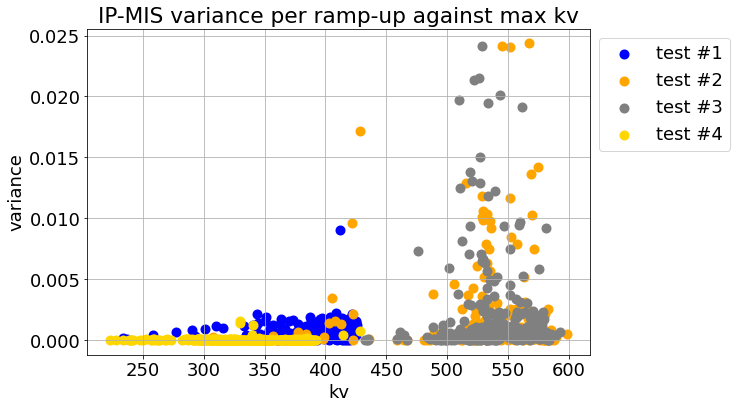

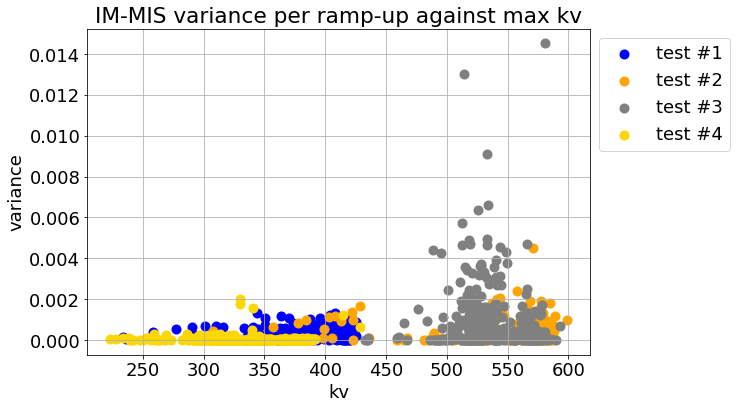

In [ ]:
plt.figure(figsize=(9,6))
#plt.hist(max_v, bins='auto')
plt.rc('font', size=18)

plt.grid()
plt.scatter(max_v1, ip_var1,  color='blue', label='test #1', linewidth=4)
plt.scatter(max_v2,ip_var2, color='orange', label='test #2', linewidth=4)
plt.scatter(max_v3,ip_var3, color='gray', label='test #3', linewidth=4)
plt.scatter(max_v4,ip_var4, color='gold', label='test #4', linewidth=4)
plt.xlabel("kv")
plt.ylabel("variance")
plt.title("IP-MIS variance per ramp-up against max kv")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

plt.figure(figsize=(9,6))
#plt.hist(max_v, bins='auto')
plt.rc('font', size=18)

plt.grid()
plt.scatter(max_v1, im_var1,  color='blue', label='test #1', linewidth=4)
plt.scatter(max_v2,im_var2, color='orange', label='test #2', linewidth=4)
plt.scatter(max_v3,im_var3, color='gray', label='test #3', linewidth=4)
plt.scatter(max_v4,im_var4, color='gold', label='test #4', linewidth=4)
plt.xlabel("kv")
plt.ylabel("variance")
plt.title("IM-MIS variance per ramp-up against max kv")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

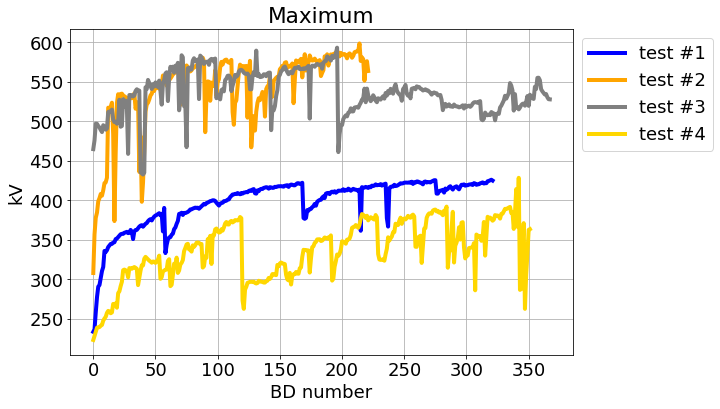

In [ ]:
max_v1 = tc1_features[0].loc[:,"value__maximum"]
max_v2 = tc2_features[0].loc[:,"value__maximum"]
max_v3 = tc3_features[0].loc[:,"value__maximum"]
max_v4 = tc4_features[0].loc[:,"value__maximum"]

ip_var1 = tc1_features[2].loc[:,"value__variance"]
ip_var2 = tc2_features[2].loc[:,"value__variance"]
ip_var3 = tc3_features[2].loc[:,"value__variance"]
ip_var4 = tc4_features[2].loc[:,"value__variance"]

im_var1 = tc1_features[1].loc[:,"value__variance"]
im_var2 = tc2_features[1].loc[:,"value__variance"]
im_var3 = tc3_features[1].loc[:,"value__variance"]
im_var4 = tc4_features[1].loc[:,"value__variance"]

plt.figure(figsize=(9,6))
#plt.hist(max_v, bins='auto')
plt.rc('font', size=18)

plt.grid()
plt.plot(max_v1,  color='blue', label='test #1', linewidth=4)
plt.plot( max_v2, color='orange', label='test #2', linewidth=4)
plt.plot(max_v3, color='gray', label='test #3', linewidth=4)
plt.plot(max_v4, color='gold', label='test #4', linewidth=4)
plt.xlabel("BD number")
plt.ylabel("kV")
plt.title("Maximum")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")